In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import numpy as np
import networkx as nx
import seaborn as sns

Text(0, 0.5, 'reliability')

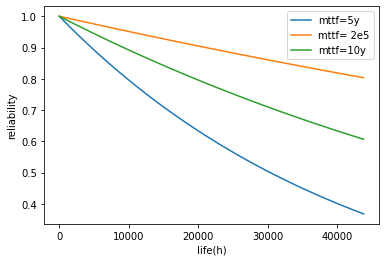

In [4]:
mttf = 5*365*24
router_rel  =  2e5 #source verbrugge 2006

x = np.linspace(0,5*365*24) #20yrs
def life(x,mttf):
    l=1/mttf
    return np.e**(-l*x)

plt.plot(x, life(x, 5*365*24), label='mttf=5y')
plt.plot(x, life(x, router_rel), label='mttf= 2e5')
plt.plot(x, life(x, 10*365*24), label='mttf=10y')
plt.legend()
plt.xlabel('life(h)')
plt.ylabel('reliability')


In [3]:
vdf = pd.read_csv("AGCOM_BBmap_opendata_sez_csv.csv", sep=';')

def get_mgb(speed):
    if speed < 2:
        return 1
    if speed < 7:
        return 2.1
    if speed < 10:
        return 3.2
    if speed < 20:
        return 7.2
    if speed < 30:
        return 21
    if speed < 100:
        return 40
    if speed < 200:
        return 50
    if speed < 1000:
        return 250

In [7]:
pont = vdf[vdf.PRO_COM_2016.isin([46004, 53004, 50014, 53013, 53020, 46026, 47018, 53022, 53028, 46034])]
pont=pont.fillna(0)
PF1 = (pont.N_ADDRESSES_ADSL+ pont.N_ADDRESSES_VDSL + pont.N_ADDRESSES_EVDSL)
pont['PF1'] = PF1
min_speed = (pont.SPEED_DOWN_ADSL_AVG.map(get_mgb) * pont.N_ADDRESSES_ADSL + pont.SPEED_DOWN_VDSL_AVG.map(get_mgb) * pont.N_ADDRESSES_VDSL + pont.SPEED_DOWN_EVDSL_AVG.map(get_mgb) * pont.N_ADDRESSES_EVDSL + 250*pont.N_ADDRESSES_FTTH)/PF1

max_speed = (pont.SPEED_DOWN_ADSL_AVG * pont.N_ADDRESSES_ADSL + pont.SPEED_DOWN_VDSL_AVG * pont.N_ADDRESSES_VDSL + pont.SPEED_DOWN_EVDSL_AVG * pont.N_ADDRESSES_EVDSL + 1000* pont.N_ADDRESSES_FTTH)/PF1


**Minimum and Maximum speed for xDSL**

In [8]:
#Minimum and Maximum speed for xDSL
print(min_speed.mean(), max_speed.mean())

7.312682750382768 12.61778211463372


**Unconnected households**

In [10]:
print(pont.PF1_SPEED_NULL.sum()/(pont.PF1_SPEED_2+pont.PF1_SPEED_30+pont.PF1_SPEED_100+pont.PF1_SPEED_500+pont.PF1_SPEED_NULL).sum())

0.18278460329381496
